# Semantic Deduplication on Text

GPU accelerated implementation of [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/abs/2303.09540)  

In [ ]:
import os

os.environ["LOGURU_LEVEL"] = "ERROR"

import pandas as pd
import pyarrow.parquet as pq

input_path = os.path.abspath("./input")
semantic_out_dir = os.path.abspath("./output/e2e")
output_path = os.path.join(semantic_out_dir, "output")
cache_path = os.path.join(semantic_out_dir, "cache")
# this can be either of jsonl or parquet
input_filetype = "parquet"
output_filetype = "parquet"  # this can be either of jsonl or parquet

## Generate Input Data

1. We generate input data if we don't have files in the path above
 - We load the tinystories dataset (just the train partition) which has 2,119,719 rows
 - We split into shards s.t. no shard has more than 10,000 rows.
 - We create a new id column which is UUID
 - We write out ~212 files

In [4]:
from nemo_curator.utils.file_utils import get_all_file_paths_under

if len(get_all_file_paths_under(input_path)) == 0:
    import os
    import uuid

    import numpy as np
    from datasets import load_dataset

    input_df = load_dataset("roneneldan/TinyStories", split="train").to_pandas()
    num_rows_per_file = 10_000

    os.makedirs(input_path, exist_ok=True)

    for i, start_idx in enumerate(range(0, len(input_df), num_rows_per_file)):
        end_idx = min(len(input_df), start_idx + num_rows_per_file)
        subset_df = input_df.iloc[start_idx:end_idx].copy()
        subset_df["id"] = [str(uuid.uuid4()) for _ in range(len(subset_df))]
        subset_df.to_parquet(os.path.join(input_path, f"part_{i}.parquet"), index=False)

    print(f"Created {len(os.listdir(input_path))} files")

Created 212 files


## Running as a single stage (e2e)

The workflow does all of things behind the scenes
1. Read original dataset
2. Run Embedding Generation 
3. Use KMeans to cluster the embeddings
4. Compute pairwise similarity inside each of the clusters
5. Identify duplicates based on `eps` provided (and `ranking_strategy`)
6. Remove duplites from the original dataset

We also allow users to also run these steps indepedently, which can be seen in the tutorial semantic_step_by_step.ipynb [TODO: Can we add link to it?]


### Performance Notes
1. Please ensure we set id_generator=True if we want to perform large scale removal also i.e. `perform_removal=True`

In [5]:
from nemo_curator.stages.deduplication.semantic import RankingStrategy
from nemo_curator.stages.text.deduplication.semantic import TextSemanticDeduplicationWorkflow

workflow = TextSemanticDeduplicationWorkflow(
    input_path=input_path,
    output_path=output_path,
    cache_path=cache_path,
    perform_removal=True,
    # Embedding generation parameters
    text_field="text",
    model_identifier="sentence-transformers/all-MiniLM-L6-v2",
    embedding_max_seq_length=512,
    embedding_max_chars=None,
    embedding_pooling="mean_pooling",
    embedding_model_inference_batch_size=256,
    # Semantic deduplication parameters
    n_clusters=100,  # this number can be much higher when the data is large
    # For large scale data we should use CURATOR_DEDUP_ID_STR if we are
    # also performing removal.
    id_field="id",
    eps=0.01,
    # K-means clustering parameters
    ranking_strategy=RankingStrategy(metadata_cols=["cosine_dist_to_cent"], ascending=True),
    pairwise_batch_size=1024,
    # ID generator parameters
    # For large scale data we should set use_id_generator to True if we are performing removal.
    use_id_generator=False,
    id_generator_state_file=None,
    # I/O parameters
    input_filetype=input_filetype,
    input_files_per_partition=1,
    output_filetype=output_filetype,
    verbose=True,
    clear_output=True,
)

In [6]:
from nemo_curator.core.client import RayClient

client = RayClient(num_cpus=64, num_gpus=4)
client.start()
try:
    workflow.run()
finally:
    client.stop()

2025-09-16 13:02:57,716	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:02:57,720	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...


2025-09-16 13:02:58,831	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2025-09-16 13:02:58,831	INFO scripts.py:913 -- Local node IP: 127.0.1.1


2025-09-16 13:03:01,880	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


2025-09-16 13:03:01,744	SUCC scripts.py:949 -- --------------------
2025-09-16 13:03:01,744	SUCC scripts.py:950 -- Ray runtime started.
2025-09-16 13:03:01,745	SUCC scripts.py:951 -- --------------------
2025-09-16 13:03:01,745	INFO scripts.py:953 -- Next steps
2025-09-16 13:03:01,745	INFO scripts.py:956 -- To add another node to this Ray cluster, run
2025-09-16 13:03:01,745	INFO scripts.py:959 --   ray start --address='127.0.1.1:6379'
2025-09-16 13:03:01,745	INFO scripts.py:968 -- To connect to this Ray cluster:
2025-09-16 13:03:01,745	INFO scripts.py:970 -- import ray
2025-09-16 13:03:01,745	INFO scripts.py:971 -- ray.init(_node_ip_address='127.0.1.1')
2025-09-16 13:03:01,745	INFO scripts.py:983 -- To submit a Ray job using the Ray Jobs CLI:
2025-09-16 13:03:01,745	INFO scripts.py:984 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1:8265' ray job submit --working-dir . -- python my_script.py
2025-09-16 13:03:01,745	INFO scripts.py:993 -- See https://docs.ray.io/en/latest/cluster/running

2025-09-16 13:03:02,684	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:03:02,686	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:03:02,687	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 10035.82it/s]
2025-09-16 13:06:14,877	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:06:14,879	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:06:14,886	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


(KMeansReadFitWriteStage pid=2184127) 203520000
(KMeansReadFitWriteStage pid=2184128) 203412096
(KMeansReadFitWriteStage pid=2184129) 203520000
(KMeansReadFitWriteStage pid=2184132) 203520000


2025-09-16 13:06:42,912	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:06:42,914	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:06:42,921	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-16 13:06:42,936	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:06:42,938	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:06:42,939	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
2025-09-16 13:07:10,047	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-16 13:07:10,049	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-16 13:07:10,056	INFO worker.py:1942 -- Connected to Ray cluster. View th

### Looking at output / cache paths

#### Embeddings

1. `id` : The id field from our original dataset. 
    - For all subsequent steps this is assumed to be the  `id_field`
    - If you had set `use_id_generator` to `True` then instead of this you would see the `_curator_dedup_id` spcified. 
        - The id in that field is generated using our IdGenerator which assigns integer ids to each row in input data that later is used in removal. 
2. `embeddings` : The embedding generated by the model we used above.

In [7]:
embeddings_path = os.path.join(cache_path, "embeddings")

pd.read_parquet(os.path.join(embeddings_path, os.listdir(embeddings_path)[0])).head()

,id,embeddings
0,f7a857b6-f2d8-4991-80ed-324f41496829,"[-0.12394736707210541, 0.010744917206466198, 0..."
1,298917d8-e269-4aef-9b60-d841fbc0ef6d,"[-0.07273813337087631, 0.06685175746679306, 0...."
2,249f2256-a10b-4dba-afb7-4d95b60636ee,"[-0.04823765903711319, 0.11327654868364334, -0..."
3,2afdfed3-f399-4d25-b23e-27f643870e07,"[-0.08059918135404587, 0.024182168766856194, -..."
4,c12efa85-804d-46fe-a6ac-940c5e6bb94e,"[-0.031761009246110916, 0.02613956294953823, 0..."


#### KMeans Results

1. `id` : The ids of the rows that belong to the cluster.
2. `embeddings` : These are later used for pairwise similarity
3. `l2_dist_to_cent` / `cosine_dist_to_cent` : This represents how far (l2 distance or cosine distance) is from our clusters centroid.
    - These fields help us define how we want to prioritize ranking within our cluster. See `RankingStratergy`
    - If we had other `metadata_fields` provided they would be used here instead.


In [8]:
kmeans_path_first_centroid = os.path.join(cache_path, "semantic_dedup", "kmeans_results", "centroid=0")

pd.read_parquet(os.path.join(kmeans_path_first_centroid, os.listdir(kmeans_path_first_centroid)[0])).head()

,id,embeddings,l2_dist_to_cent,cosine_dist_to_cent
0,d9ea3653-4995-428a-82bd-fbdddf3a3f07,"[-0.045619637, 0.02869307, 0.04971463, 0.04870...",0.666160,0.252270
1,67347027-46e8-4f9a-9d6a-89f5caa9a146,"[-0.033726413, 0.06598548, 0.034210414, 0.0044...",0.646775,0.236389
2,3a319825-3d81-4c85-9887-b5f83e3a10d5,"[-0.0750781, 0.01703193, 0.062773034, -0.01165...",0.516329,0.141716
3,e1c8648d-7e77-4081-b050-64eb5ddff708,"[-0.022374246, 0.045000467, 0.08037134, 0.1068...",0.638294,0.229588
4,b9010c1d-522f-4eb1-9a97-f55874f25e5b,"[-0.058193002, 0.01640579, 0.03337666, 0.04800...",0.603638,0.202732


#### Pairwise Similarity Result

1. `id` : The identifier for the duplicate row.
2. `max_id` : The closest pair for the duplicate row.
3. `cosine_sim_score` : The cosine similarity between the two points


In [27]:
pairwise_path = os.path.join(cache_path, "semantic_dedup", "pairwise_results")

pd.read_parquet(os.path.join(pairwise_path, "cluster_0.parquet")).head()

,id,max_id,cosine_sim_score
0,6bd1477c-1303-451b-8a99-6b5d02f89778,6bd1477c-1303-451b-8a99-6b5d02f89778,0.000000
1,0a7d2ba8-af4a-4d0d-ba17-a4bae1523269,6bd1477c-1303-451b-8a99-6b5d02f89778,0.932138
2,53f75eff-d45e-4c76-9ce7-c0a3bfa6ac5f,6bd1477c-1303-451b-8a99-6b5d02f89778,0.936246
3,dc45be58-58e3-4358-90db-541ad00faf8f,6bd1477c-1303-451b-8a99-6b5d02f89778,0.915550
4,a6cadb30-44a7-48cb-8966-da3a1e3607d7,6bd1477c-1303-451b-8a99-6b5d02f89778,0.928383


##### Looking at similar results

We can look at two rows and see why the embedding model thinks they're similar.
We can use this to guide our decision about the `eps` parameter.

We use two `0a7d2ba8-af4a-4d0d-ba17-a4bae1523269` and	`6bd1477c-1303-451b-8a99-6b5d02f89778` which have cosine similarity of	`0.932138`.

And we notice that the theme of the data is very similar. 

**NOTE : If you run with `use_id_generator=True` (which is important to perform removal at large scale) you will see the ids which were generated internally, and there won't be a way to perform this step, as there is no simple way of getting old mapping of id to new mapping of id. **

In [49]:
from pprint import pprint

pprint(
    pd.read_parquet(
        input_path,
        filters=[("id", "in", {"0a7d2ba8-af4a-4d0d-ba17-a4bae1523269", "6bd1477c-1303-451b-8a99-6b5d02f89778"})],
    ).to_dict(orient="records")
)

[{'id': '0a7d2ba8-af4a-4d0d-ba17-a4bae1523269',
  'text': 'Once upon a time, there was a little girl named Lily. She lived in '
          "a big house with her mommy and daddy. One day, Lily's mommy said, "
          '"Lily, we need to hurry and get ready to go to the park."\n'
          '\n'
          'Lily replied, "Okay mommy, I will be very fast." She put on her '
          'shoes and ran to the car.\n'
          '\n'
          'When they got to the park, Lily saw lots of other kids playing. One '
          'boy was playing with a ball and accidentally hit it towards Lily. '
          '"I\'m sorry," he said in a thoughtful voice.\n'
          '\n'
          '"It\'s okay," Lily said with a smile. "Let\'s play together!"\n'
          '\n'
          'They played together for a long time and had so much fun. Lily was '
          'happy to have made a new friend from a different nation. When it '
          'was time to go home, Lily said goodbye to her new friend and '
          'thanke

##### Visualizing Similarity in our dataset


Depending on our dataset size we can read through all of the files and plot how much data is similar to one another.
Here we show how to read file by file and then perform a reduce. 

In our dataset we can see that ~20% of our data has cosine_similarity of 0.9 or more.

Based on the analysis here and above (where we see similar text fields) we can decide what our `eps` should be. 
However in this tutorial we pre-ran with eps set and perform_removal to be True.

However ideally, users do this analysis, inspect the duplicates, come up with an `eps` and then run a pipeline that includes the `IdentifyDuplicates` stage; and finally perform removal.

In [51]:
from collections import Counter
from functools import reduce

import numpy as np


def get_bins(df: pd.DataFrame, num_bins: int = 1_000) -> dict[float, int]:
    bins = np.linspace(0, 1.01, num_bins)

    return Counter(
        pd.cut(df["cosine_sim_score"], bins=bins, labels=bins[1:], retbins=False, include_lowest=True, right=True)
        .value_counts()
        .to_dict()
    )


similarity_across_dataset = reduce(
    lambda x, y: x + y,
    [
        get_bins(pd.read_parquet(os.path.join(pairwise_path, f), columns=["cosine_sim_score"]), num_bins=1000)
        for f in os.listdir(pairwise_path)
    ],
)

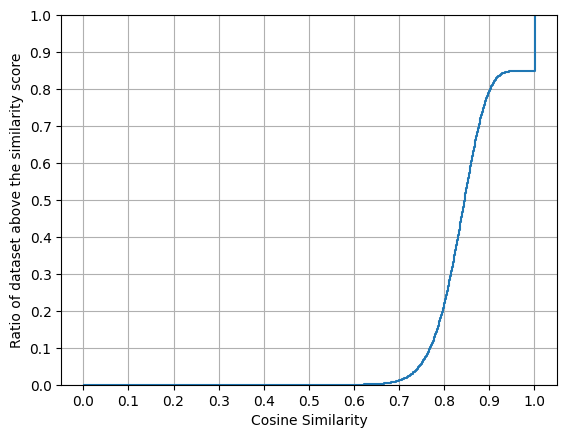

In [ ]:
import matplotlib.pyplot as plt

plt.ecdf(x=similarity_across_dataset.keys(), weights=similarity_across_dataset.values())
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Cosine Similarity")
plt.ylabel("Ratio of dataset below the similarity score")
plt.grid()
plt.show()

#### Looking at duplicates

- `id` : This is a list of all ids that are above our similarity threshold `eps`.

In [53]:
duplicates_path = os.path.join(output_path, "duplicates")

pd.read_parquet(os.path.join(duplicates_path, os.listdir(duplicates_path)[0])).head()

,id
0,0000262b-4ec2-46cb-899d-9a11764bbeda
1,000470c9-d4ab-4804-9141-b059da860694
2,0005a527-9792-4ff1-8d3e-5c4b320487a5
3,0005dbd4-94bb-48a1-96dc-ef4d363d2750
4,0006d2d0-945a-4d56-972b-5ae308621f0d


In [63]:
num_duplicates = sum(pq.read_metadata(os.path.join(duplicates_path, f)).num_rows for f in os.listdir(duplicates_path))
print(f"We found {num_duplicates:,} duplicates in the dataset")

We found 320,464 duplicates in the dataset


#### Looking at deduplicated dataset

Here we see all the original columns. 

We can control the schema of this by specifying the `output_fields` arg in the workflow definition.

If you had set use_id_generator then you'd see `_curator_dedup_id` here as well.

In [64]:
deduplicated_path = os.path.join(output_path, "deduplicated")

pd.read_parquet(os.path.join(deduplicated_path, os.listdir(deduplicated_path)[0])).head()

,text,id
0,"Once upon a time, there was a big dog named Ma...",6ad1b334-45b4-4a03-a4a9-73f130b52b0a
1,"Once upon a time, there was a shy little girl ...",f7ca673a-ed1e-43f1-82b9-ed9c373a166d
2,"Once upon a time, there was a little boy named...",eefa6898-5edd-4d29-ad7b-6cf7af418b07
3,"Once upon a time, there was a little girl name...",315b7ead-1c98-4e21-a22a-dd5140822613
4,"Once upon a time, there was a little girl name...",ad2f7f66-d20a-4bd5-9263-a5f96aa5bca8


In [65]:
num_deduplicated = sum(
    pq.read_metadata(os.path.join(deduplicated_path, f)).num_rows for f in os.listdir(deduplicated_path)
)
print(f"Our final dataset has {num_deduplicated:,} rows")

Our final dataset has 1,799,255 rows
